# Spiral Problem

This document presents a fictitious problem of learning the length of a spiral; we use this problem as a proof of concept in a publication:
"*Local Interpretation Methods to Machine Learning Using the Domain of the Feature Space*"

The equation of the features x<sub>1</sub> and x<sub>2</sub> and target is given by:
<img src="../images/eq_spiral.png" alt="drawing" width="300"/>
where x1 and x2 are the values that form the feature vector x = (x<sub>1</sub>, x<sub>2</sub>), θ is a independent
variable, &epsilon;<sub>i</sub> i ∈ {1, 2}, is a random noise, and the target value is given by y, the length of the spiral. This toy model presents some interesting features for our analysis, such as the feature domain over the spiral and the substantial variance of the target value when varying one of the coordinates of the feature while keeping the other one fixed.

In [1]:
import sys
sys.path.append('../..')
from sklearn.datasets import load_boston
import sklearn.ensemble
from sklearn import metrics
import numpy as np

from matplotlib import pyplot as plt
# import seaborn as sns
import pandas as pd

from playground.aux.domain import Spiral
import lime.lime_tabular
from density_lime.lime_tabular import DensityLimeTabularExplainer

from sklearn.linear_model import HuberRegressor as Linear
# from sklearn.linear_model import SGDRegressor as Linear

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data spiral

In [2]:
data = Spiral(n_samples=10000, theta_domain=[2*np.pi, 2.5*np.pi], error_x=0.1)

In [3]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data.data, data.target, train_size=0.80)

In [4]:
df = pd.DataFrame(data.data, columns=data.feature_names)

# Training a RF Model

In [5]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [6]:
print('R2: ', metrics.r2_score(y_test, rf.predict(x_test)))
print('Random Forest MSError', np.mean((rf.predict(x_test) - y_test) ** 2))
print('MSError when predicting the mean', np.mean((y_train.mean() - y_test) ** 2))


R2:  0.9990590881858105
Random Forest MSError 0.501071825273492
MSError when predicting the mean 532.629873373027


# Interpretation and Explanation

In [7]:
categorical_features = np.argwhere(np.array([len(set(data.data[:,x])) for x in range(data.data.shape[1])]) <= 10).flatten()

In [8]:
categorical_features

array([], dtype=int64)

## Explanation for instance x<sup>1</sup> = (0.0, 8.5):

For the point x<sup>1</sup>, the target value (the length of the spiral) will locally depend on the value of x<sub>1</sub> , thus the explanation methods should indicate that variable as the most important.

In [9]:
x_explain = np.array([0.0, 8.0])

Text(0, 0.5, '$x_2$')

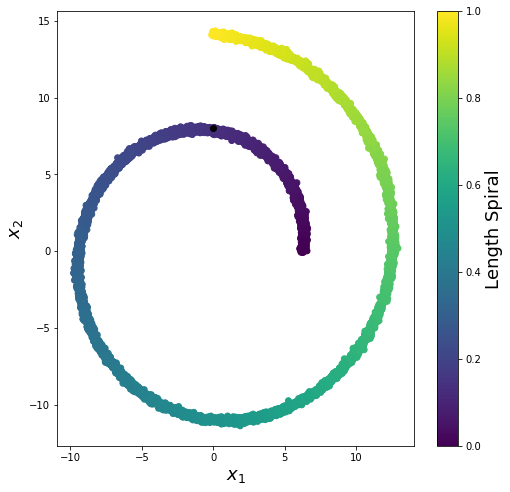

In [10]:
fig, ax = data.plot()
cp = ax.scatter(x_explain[0], x_explain[1], c='black')
color = plt.colorbar(cp)
fig.set_size_inches(8,8)
color.set_label(label='Length Spiral', size=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)

### Normal Lime

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=data.feature_names
        , class_names=['price'], categorical_features=categorical_features, verbose=True, mode='regression')

In [12]:
exp = explainer.explain_instance(x_explain, rf.predict, num_features=5,  model_regressor=Linear())

Intercept 59.18268559519661
Prediction_local [74.75780852]
Right: 32.51820157192779


The Prediction_local and Right do not agree, decreasing the user trust in the produced interpretation.

In [13]:
exp.show_in_notebook(show_table=True)

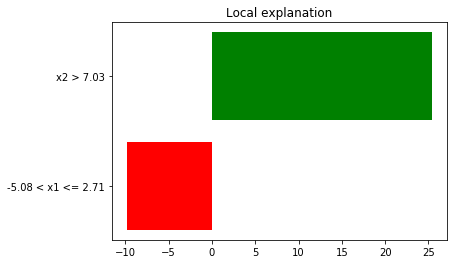

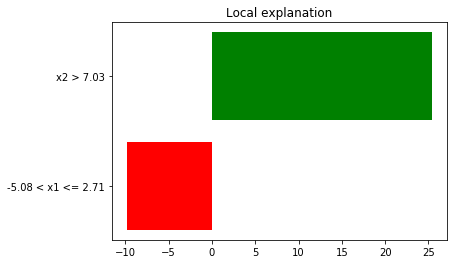

In [14]:
exp.as_pyplot_figure()

This explanation is not correct, the x<sub>2</sub> is given as the most important feature. 


### Density KDE Lime

Now, we use Kernel Density Estimation (KDE) to obtain an estimative of the manifold of the feature space. Then, the interpretation is produced from samples drawn from this estimative close from the instance x<sup>1</sup>

In [15]:
explainer_mani = DensityLimeTabularExplainer(x_train, sample_around_instance=True, manifold='kde'
    , feature_names=data.feature_names, class_names=['price'], categorical_features=categorical_features
    , verbose=True, mode='regression', discretize_continuous=False, manifold_params={'search_best':False})
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict, num_features=5
    , r_density=0.1, model_regressor=Linear(), scale_data=False)

Intercept 32.21835053494048
Prediction_local [32.47784421]
Right: 32.51820157192779


In [16]:
exp_mani.show_in_notebook(show_table=True)

In [17]:
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict, num_features=5
    , r_density=0.1, model_regressor=Linear(), scale_data=False)

Intercept 32.22370785332886
Prediction_local [32.4776753]
Right: 32.51820157192779


The Prediction_local and Right have a good agreement, increasing the user trust in the produced interpretation.

#### Visualization of the sampled data:

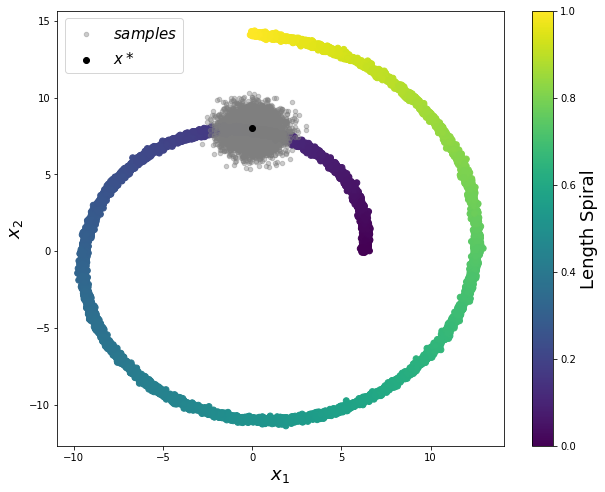

In [18]:
fig, ax = data.plot()
cp = ax.scatter(explainer_mani.data[:, 0], explainer_mani.data[:, 1], s=20, c='tab:gray', alpha=0.4, label='$samples$')
cp = ax.scatter(x_explain[0], x_explain[1], c='black', label='$x*$')
color = plt.colorbar(cp)
fig.set_size_inches(10,8)
color.set_label(label='Length Spiral', size=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.legend(fontsize=15)

This results show the importance the importance to correct define the neigbordhood to produce meaninful intepretation for a instance.

In [19]:
from density_lime.explanations.linear import ExplainLinear
from density_lime.densities.density_kde import DensityKDE

In [20]:
density = DensityKDE().fit(x_train)

Best Parameter for the KDE:
{'bandwidth': 0.06444444444444444}
Score: -5710.156397673255


In [21]:
explaniner = ExplainLinear(
    model_predict=rf.predict
    , density=density, linear_model='HuberRegressor', verbose=True)
explaniner.explain_instance(
    x_explain.reshape(1, -1), r=0.2, n_samples=1000, mini_local_batch_max=5000)

--- step: 0 ----
importance: [-0.61911861 -0.03931146]
importance diff: 0.001
score: 0.6683209815453797
--- step: 1 ----
importance: [-0.65436817 -0.02284087]
importance diff: 0.05172015699414782
score: 0.693792564624803
--- step: 2 ----
importance: [-0.61634176 -0.04172861]
importance diff: 0.056914155639387204
score: 0.6619556124625194
--- step: 3 ----
importance: [-0.61619693 -0.02623092]
importance diff: 0.01564251651987499
score: 0.6755167334798184
--- step: 4 ----
importance: [-0.60610855 -0.06354026]
importance diff: 0.04739772191930333
score: 0.6821401505617332
--- step: 5 ----
importance: [-0.64313309 -0.01946029]
importance diff: 0.08110451263749924
score: 0.6778249222920594
--- step: 6 ----
importance: [-0.59605605 -0.03457941]
importance diff: 0.062196169685974724
score: 0.6535847177239442
--- step: 7 ----
importance: [-0.62638657 -0.01108779]
importance diff: 0.05382214759731357
score: 0.677570451173412
--- step: 8 ----
importance: [-0.62658801 -0.03633748]
importance diff

--- step: 69 ----
importance: [-0.59662831 -0.02955599]
importance diff: 0.06256117896543816
score: 0.652986563215073
--- step: 70 ----
importance: [-0.62140279 -0.03658977]
importance diff: 0.031808266939659456
score: 0.6873903979094376
--- step: 71 ----
importance: [-0.59596621 -0.0255552 ]
importance diff: 0.03647115669982773
score: 0.6519179791139249
--- step: 72 ----
importance: [-0.62208139 -0.0559979 ]
importance diff: 0.05655787843184522
score: 0.6725262433655895
--- step: 73 ----
importance: [-0.67141866 -0.03861064]
importance diff: 0.06672453520268587
score: 0.7280638328374367
--- step: 74 ----
importance: [-0.64177142 -0.01410187]
importance diff: 0.054156001945750765
score: 0.697093240997317
--- step: 75 ----
importance: [-0.60989066 -0.02826663]
importance diff: 0.04604551892624477
score: 0.6543515106281077
--- step: 76 ----
importance: [-0.61276086 -0.05530104]
importance diff: 0.02990461034682238
score: 0.6438720255503081
--- step: 77 ----
importance: [-0.60602811 -0.04

--- step: 140 ----
importance: [-0.63331239 -0.03191909]
importance diff: 0.06778093713840615
score: 0.6888542666969918
--- step: 141 ----
importance: [-0.66204674 -0.0315362 ]
importance diff: 0.029117233860927016
score: 0.6875579597612724
--- step: 142 ----
importance: [-0.61945731 -0.03185555]
importance diff: 0.04290877942499765
score: 0.671783617642646
--- step: 143 ----
importance: [-0.5851661  -0.05009563]
importance diff: 0.052531281648733066
score: 0.6513375490441815
--- step: 144 ----
importance: [-0.57693832 -0.04951031]
importance diff: 0.008813099110073518
score: 0.6527051140469411
--- step: 145 ----
importance: [-0.66004998 -0.04274757]
importance diff: 0.08987439480312409
score: 0.6968876303228804
--- step: 146 ----
importance: [-0.59630006 -0.03533375]
importance diff: 0.07116374470938489
score: 0.6660563196925718
--- step: 147 ----
importance: [-0.63180105 -0.0172022 ]
importance diff: 0.053632542607704684
score: 0.6939095439473839
--- step: 148 ----
importance: [-0.63

{'importance': array([-0.6392266 , -0.02786359])}

In [22]:
explaniner = ExplainLinear(
    model_predict=rf.predict, density=density, linear_model='Ridge', verbose=True)
explaniner.explain_instance(
    x_explain.reshape(1, -1), r=0.2, n_samples=1000, mini_local_batch_max=5000)

--- step: 0 ----
importance: [-0.62298317  0.01642742]
importance diff: 0.001
score: 0.6933297308970174
--- step: 1 ----
importance: [-0.64161632  0.01117256]
importance diff: 0.023888017674189008
score: 0.6809317421671841
--- step: 2 ----
importance: [-0.66119466  0.01035015]
importance diff: 0.02040075036825576
score: 0.6987427211418203
--- step: 3 ----
importance: [-0.6540851  0.0070127]
importance diff: 0.010447018354810766
score: 0.6575530288466864
--- step: 4 ----
importance: [-0.66155598  0.00476775]
importance diff: 0.009715824133677487
score: 0.6970967527508781
--- step: 5 ----
importance: [-0.66826644  0.00085621]
importance diff: 0.010621994182176653
score: 0.7009077852337572
--- step: 6 ----
importance: [-0.67022054  0.00323355]
importance diff: 0.004331441093700144
score: 0.6829912012285289
--- step: 7 ----
importance: [-0.67100609  0.0043481 ]
importance diff: 0.0019000994580345722
score: 0.6887428884589692
--- step: 8 ----
importance: [-0.6685903   0.00339166]
importance

{'importance': array([-0.66984248, -0.00363585])}

In [23]:
explaniner = ExplainLinear(
    model_predict=rf.predict, density=density, linear_model='SGD', verbose=True)
explaniner.explain_instance(
    x_explain.reshape(1, -1), r=0.2, n_samples=1000, mini_local_batch_max=10000)

--- step: 0 ----
importance: [-0.09682117  4.07390191]
importance diff: 0.001
score: -30.6909079904983
--- step: 1 ----
importance: [-0.15759861  4.05497968]
importance diff: 0.07969966895716896
score: -20.79401444590414
--- step: 2 ----
importance: [-0.19271757  4.04015533]
importance diff: 0.04994330639473271
score: -16.697732774275956
--- step: 3 ----
importance: [-0.24178075  4.02634939]
importance diff: 0.0628691187653615
score: -16.36539484818792
--- step: 4 ----
importance: [-0.25197204  4.01859091]
importance diff: 0.017949771952608023
score: -17.75906658926101
--- step: 5 ----
importance: [-0.26035171  4.00557497]
importance diff: 0.021395611785464508
score: -14.096678690933349
--- step: 6 ----
importance: [-0.28179924  3.97103521]
importance diff: 0.05598728653875257
score: -20.903206063656857
--- step: 7 ----
importance: [-0.31725615  3.98309611]
importance diff: 0.047517821554450834
score: -14.28273049235696
--- step: 8 ----
importance: [-0.33865856  4.00827573]
importance 

--- step: 72 ----
importance: [-0.48965579  3.65567983]
importance diff: 0.013859163542816855
score: -14.970208866221471
--- step: 73 ----
importance: [-0.49458631  3.62196143]
importance diff: 0.03864891778197771
score: -12.708273413707607
--- step: 74 ----
importance: [-0.51448708  3.6205227 ]
importance diff: 0.02133950311007088
score: -12.475569820402438
--- step: 75 ----
importance: [-0.51675639  3.58199303]
importance diff: 0.04079898026609019
score: -24.80626359981661
--- step: 76 ----
importance: [-0.5243811   3.67091901]
importance diff: 0.09655069228705837
score: -31.431414369464175
--- step: 77 ----
importance: [-0.5292036  3.597744 ]
importance diff: 0.07799752132341087
score: -13.271771550224052
--- step: 78 ----
importance: [-0.50720171  3.57037409]
importance diff: 0.04937179584471629
score: -23.33106887735584
--- step: 79 ----
importance: [-0.50618424  3.58961457]
importance diff: 0.020257940258131768
score: -12.498217031743676
--- step: 80 ----
importance: [-0.51696494

--- step: 152 ----
importance: [-0.49409598  3.25322553]
importance diff: 0.015921753365976843
score: -8.319830530711954
--- step: 153 ----
importance: [-0.49632369  3.29427694]
importance diff: 0.043279126572865145
score: -28.161107995507997
--- step: 154 ----
importance: [-0.49337365  3.24209017]
importance diff: 0.05513681317668795
score: -9.225880049463788
--- step: 155 ----
importance: [-0.48779891  3.24673538]
importance diff: 0.010219951078892842
score: -8.517679853481487
--- step: 156 ----
importance: [-0.51417367  3.23578346]
importance diff: 0.03732669015504475
score: -9.33444857309397
--- step: 157 ----
importance: [-0.51675177  3.22681234]
importance diff: 0.011549215884288033
score: -8.942801333598993
--- step: 158 ----
importance: [-0.51485415  3.21462092]
importance diff: 0.014089034343373719
score: -9.555766571558726
--- step: 159 ----
importance: [-0.5283702   3.22527322]
importance diff: 0.024168349587719407
score: -7.824819283243366
--- step: 160 ----
importance: [-0

--- step: 231 ----
importance: [-0.53221975  2.937569  ]
importance diff: 0.014628820081669547
score: -13.062317423155239
--- step: 232 ----
importance: [-0.51511021  2.94683329]
importance diff: 0.0263738330883031
score: -19.7513856678274
--- step: 233 ----
importance: [-0.51596099  2.84778311]
importance diff: 0.09990095294243362
score: -29.117533059806217
--- step: 234 ----
importance: [-0.49754728  2.89025073]
importance diff: 0.06088132977895189
score: -8.263885907932131
--- step: 235 ----
importance: [-0.49109451  2.87311888]
importance diff: 0.023584626588778468
score: -11.850817763742038
--- step: 236 ----
importance: [-0.494816    2.91510168]
importance diff: 0.04570430305833467
score: -12.874168040509199
--- step: 237 ----
importance: [-0.48943482  2.89487972]
importance diff: 0.025603154182801013
score: -7.905890326699323
--- step: 238 ----
importance: [-0.49001345  2.89412104]
importance diff: 0.0013373158951477393
score: -9.167453953605927
--- step: 239 ----
importance: [-

--- step: 313 ----
importance: [-0.53388907  2.58657559]
importance diff: 0.03188879417620272
score: -5.864170619689271
--- step: 314 ----
importance: [-0.53322233  2.62207418]
importance diff: 0.036165336050826835
score: -14.684738192305728
--- step: 315 ----
importance: [-0.52963385  2.58715914]
importance diff: 0.03850351762480131
score: -6.817164634182128
--- step: 316 ----
importance: [-0.54073473  2.57399714]
importance diff: 0.02426287932544402
score: -5.491171649030903
--- step: 317 ----
importance: [-0.55132763  2.58256626]
importance diff: 0.019162011132381696
score: -5.427625310665103
--- step: 318 ----
importance: [-0.54114327  2.58431046]
importance diff: 0.011928550990382147
score: -7.013486394468906
--- step: 319 ----
importance: [-0.53749475  2.55008867]
importance diff: 0.03787030866766039
score: -7.9382719819242284
--- step: 320 ----
importance: [-0.52972635  2.52321982]
importance diff: 0.0346372479291871
score: -17.731613054609692
--- step: 321 ----
importance: [-0.

score: -4.6220481807320954
--- step: 396 ----
importance: [-0.5685931   2.30269823]
importance diff: 0.01733137179826083
score: -4.279641551555854
--- step: 397 ----
importance: [-0.56894523  2.31128294]
importance diff: 0.008936840796665457
score: -6.3144223014549015
--- step: 398 ----
importance: [-0.57069452  2.29404406]
importance diff: 0.018988180256354514
score: -4.19436434124359
--- step: 399 ----
importance: [-0.57572704  2.29715752]
importance diff: 0.008145980944416986
score: -4.436826278835327
--- step: 400 ----
importance: [-0.57120213  2.28525371]
importance diff: 0.016428726670574156
score: -4.703866970470945
--- step: 401 ----
importance: [-0.56596874  2.27656307]
importance diff: 0.013924022763671107
score: -5.655536169300657
--- step: 402 ----
importance: [-0.55945295  2.28209042]
importance diff: 0.012043142103399962
score: -4.935727256289802
--- step: 403 ----
importance: [-0.57259992  2.27336134]
importance diff: 0.021876050436113514
score: -4.593528591101197
--- st

--- step: 478 ----
importance: [-0.55276343  2.05110121]
importance diff: 0.009206224805020757
score: -3.6992988105743203
--- step: 479 ----
importance: [-0.55053208  2.06402733]
importance diff: 0.015157481810331608
score: -5.0932840726361635
--- step: 480 ----
importance: [-0.55025426  2.06564953]
importance diff: 0.0019000163242578472
score: -5.69774316034767
--- step: 481 ----
importance: [-0.55631045  2.03736374]
importance diff: 0.034341982695803575
score: -3.571448766082834
--- step: 482 ----
importance: [-0.56262352  2.05688927]
importance diff: 0.025838593710327817
score: -6.290651604731182
--- step: 483 ----
importance: [-0.5759059   2.05217857]
importance diff: 0.01799308066504457
score: -4.488644977193628
--- step: 484 ----
importance: [-0.57093782  2.0283107 ]
importance diff: 0.028835938155781893
score: -3.890390536026917
--- step: 485 ----
importance: [-0.57847463  2.04817255]
importance diff: 0.027398651176384514
score: -5.2934513191877794
--- step: 486 ----
importance:

importance diff: 0.007600592835661835
score: -2.628774271017009
--- step: 559 ----
importance: [-0.5846962   1.84579157]
importance diff: 0.020582435836344004
score: -4.978241076773567
--- step: 560 ----
importance: [-0.58402554  1.82800787]
importance diff: 0.018454365823845853
score: -2.8445705468100386
--- step: 561 ----
importance: [-0.57543335  1.85371628]
importance diff: 0.034300603822992715
score: -10.731812044643119
--- step: 562 ----
importance: [-0.56713874  1.81229366]
importance diff: 0.049717237477200804
score: -2.8000753266820615
--- step: 563 ----
importance: [-0.56888886  1.81333552]
importance diff: 0.0027919809796213
score: -2.2677357646594496
--- step: 564 ----
importance: [-0.55776135  1.82949865]
importance diff: 0.027290642375172536
score: -4.864303701677368
--- step: 565 ----
importance: [-0.56922021  1.80007254]
importance diff: 0.040884970621455574
score: -3.133159764763745
--- step: 566 ----
importance: [-0.5621134   1.81786601]
importance diff: 0.02490028003

--- step: 640 ----
importance: [-0.5684902   1.63611365]
importance diff: 0.013028816497120288
score: -2.109174860009022
--- step: 641 ----
importance: [-0.56668988  1.63090151]
importance diff: 0.0070124613011138814
score: -2.1549949901288175
--- step: 642 ----
importance: [-0.5802563   1.62178482]
importance diff: 0.02268311007500101
score: -1.8897505166105648
--- step: 643 ----
importance: [-0.58326672  1.6114452 ]
importance diff: 0.01335004287192565
score: -2.832082317086867
--- step: 644 ----
importance: [-0.57741176  1.61455205]
importance diff: 0.008961811541110865
score: -2.3583334101969693
--- step: 645 ----
importance: [-0.57451972  1.61280734]
importance diff: 0.004636734716596647
score: -2.3677345224389414
--- step: 646 ----
importance: [-0.58647157  1.61043993]
importance diff: 0.014319269104278609
score: -2.0052318380119574
--- step: 647 ----
importance: [-0.58626042  1.61954995]
importance diff: 0.009321171732153855
score: -2.100565622590173
--- step: 648 ----
importanc

--- step: 719 ----
importance: [-0.58153653  1.45214518]
importance diff: 0.02403291501143545
score: -1.6394215016372051
--- step: 720 ----
importance: [-0.58460288  1.4517341 ]
importance diff: 0.0034774235584742463
score: -1.5665397817888933
--- step: 721 ----
importance: [-0.58525427  1.44329773]
importance diff: 0.00908776053077509
score: -2.4571149046862044
--- step: 722 ----
importance: [-0.57674393  1.44661489]
importance diff: 0.011827503911880033
score: -1.7425743221314662
--- step: 723 ----
importance: [-0.5621638   1.45503083]
importance diff: 0.022996063367148656
score: -1.6160551798505125
--- step: 724 ----
importance: [-0.56674158  1.45282724]
importance diff: 0.006781370259397956
score: -1.4540754907092683
--- step: 725 ----
importance: [-0.56712692  1.45650756]
importance diff: 0.004065649257259607
score: -1.7252780506771948
--- step: 726 ----
importance: [-0.57353635  1.43634948]
importance diff: 0.026567512416419636
score: -1.9565244202865957
--- step: 727 ----
import

score: -0.8535573942680408
--- step: 802 ----
importance: [-0.58524352  1.31965329]
importance diff: 0.022179140894432625
score: -4.567558888353941
--- step: 803 ----
importance: [-0.58482809  1.29988421]
importance diff: 0.02018450987587095
score: -0.9371836563893652
--- step: 804 ----
importance: [-0.58714828  1.30474503]
importance diff: 0.007181005517005845
score: -1.6572289133394311
--- step: 805 ----
importance: [-0.58713655  1.29252053]
importance diff: 0.012236222556993082
score: -0.9579374426610022
--- step: 806 ----
importance: [-0.58119727  1.28902228]
importance diff: 0.009437538025321435
score: -1.0860171883240115
--- step: 807 ----
importance: [-0.57534879  1.2743176 ]
importance diff: 0.020553153579074057
score: -3.046210263089562
--- step: 808 ----
importance: [-0.58039997  1.27785262]
importance diff: 0.008586194073844644
score: -1.5238016709996312
--- step: 809 ----
importance: [-0.58714206  1.27208832]
importance diff: 0.012506386003607206
score: -2.190718323428924
-

--- step: 881 ----
importance: [-0.57147481  1.14010734]
importance diff: 0.03218977258651323
score: -4.383980841976482
--- step: 882 ----
importance: [-0.56894766  1.16088367]
importance diff: 0.023303484961051613
score: -0.7873201768200564
--- step: 883 ----
importance: [-0.56549847  1.17777761]
importance diff: 0.020343127872444966
score: -3.597322146328432
--- step: 884 ----
importance: [-0.5633587   1.15372753]
importance diff: 0.026189844568620613
score: -0.8053330618703896
--- step: 885 ----
importance: [-0.57619151  1.16255733]
importance diff: 0.021662608551499596
score: -1.171445190346537
--- step: 886 ----
importance: [-0.58680034  1.1459899 ]
importance diff: 0.02717626958985231
score: -0.8077322201799315
--- step: 887 ----
importance: [-0.59270541  1.15916348]
importance diff: 0.019078653526817146
score: -0.8943736929221945
--- step: 888 ----
importance: [-0.59634737  1.13624367]
importance diff: 0.026561764571328972
score: -2.0363560880601526
--- step: 889 ----
importance

--- step: 963 ----
importance: [-0.60025047  1.03114703]
importance diff: 0.009353555652851564
score: -0.431177482475227
--- step: 964 ----
importance: [-0.59804734  1.03088103]
importance diff: 0.0024691342522820126
score: -0.3876679280888313
--- step: 965 ----
importance: [-0.59942234  1.030827  ]
importance diff: 0.0014290235435014953
score: -0.30336094396647995
--- step: 966 ----
importance: [-0.59365142  1.03732527]
importance diff: 0.012269196770118063
score: -0.8804713037903797
--- step: 967 ----
importance: [-0.58707711  1.04379893]
importance diff: 0.013047961470166292
score: -2.303466538732142
--- step: 968 ----
importance: [-0.59214     1.03847348]
importance diff: 0.010388337205198828
score: -1.1013683646036907
--- step: 969 ----
importance: [-0.58633232  1.01673767]
importance diff: 0.027543484751243574
score: -0.9045027287509337
--- step: 970 ----
importance: [-0.58035114  1.01807155]
importance diff: 0.007315065528985976
score: -0.504598337324341
--- step: 971 ----
impor

--- step: 1041 ----
importance: [-0.6021061   0.91946289]
importance diff: 0.006791817342174156
score: -0.39599887919229393
--- step: 1042 ----
importance: [-0.5969137   0.93533238]
importance diff: 0.02106188397278641
score: -0.8800187389873468
--- step: 1043 ----
importance: [-0.59661631  0.91883795]
importance diff: 0.016791818018753735
score: -0.3567766976791864
--- step: 1044 ----
importance: [-0.60115146  0.91162595]
importance diff: 0.011747152285232931
score: -0.9989227529447099
--- step: 1045 ----
importance: [-0.60852234  0.92935159]
importance diff: 0.02509651861330242
score: -0.4735090300942555
--- step: 1046 ----
importance: [-0.60728062  0.9203851 ]
importance diff: 0.010208210129561635
score: 0.003117887868722913
--- step: 1047 ----
importance: [-0.60270099  0.92505543]
importance diff: 0.009249969565900407
score: -0.28440084545166955
--- step: 1048 ----
importance: [-0.60584736  0.9110285 ]
importance diff: 0.017173305914522707
score: -0.47211623358092436
--- step: 1049

--- step: 1120 ----
importance: [-0.58655268  0.82069174]
importance diff: 0.021032163545604998
score: -0.33793999798906316
--- step: 1121 ----
importance: [-0.58338316  0.83034545]
importance diff: 0.012823235120275056
score: -0.1390347856696812
--- step: 1122 ----
importance: [-0.57827539  0.81060159]
importance diff: 0.024851628791209168
score: -1.87525464855743
--- step: 1123 ----
importance: [-0.58360726  0.81528161]
importance diff: 0.010011883857776405
score: -0.7608691207583835
--- step: 1124 ----
importance: [-0.58672787  0.82221684]
importance diff: 0.0100558491537045
score: 0.073554350138605
--- step: 1125 ----
importance: [-0.58521331  0.83619797]
importance diff: 0.015495692731310018
score: -1.6475166572817743
--- step: 1126 ----
importance: [-0.58327552  0.83026974]
importance diff: 0.00786603014528775
score: -0.45804699367798785
--- step: 1127 ----
importance: [-0.58538867  0.82060888]
importance diff: 0.011774012652645327
score: 0.05602771409795926
--- step: 1128 ----
i

--- step: 1198 ----
importance: [-0.59491713  0.74662097]
importance diff: 0.00896123794845094
score: 0.01971628649925128
--- step: 1199 ----
importance: [-0.59314296  0.74420419]
importance diff: 0.004190958109420939
score: 0.11820967026643081
--- step: 1200 ----
importance: [-0.59298091  0.73488549]
importance diff: 0.009480752608371112
score: -0.04853434644309251
--- step: 1201 ----
importance: [-0.60177911  0.74392076]
importance diff: 0.017833481997452272
score: 0.02220817166103939
--- step: 1202 ----
importance: [-0.60168917  0.73847622]
importance diff: 0.005534484606484091
score: 0.19057519189729433
--- step: 1203 ----
importance: [-0.60489699  0.73445078]
importance diff: 0.007233263644662591
score: 0.09606037733932704
--- step: 1204 ----
importance: [-0.60385814  0.73264134]
importance diff: 0.0028482877944076
score: 0.1009495817744609
--- step: 1205 ----
importance: [-0.59862696  0.73559319]
importance diff: 0.008183039059716068
score: 0.06811905257262407
--- step: 1206 ----

--- step: 1277 ----
importance: [-0.59139265  0.66360837]
importance diff: 0.005866433952653516
score: 0.2791783560386025
--- step: 1278 ----
importance: [-0.596969    0.67220079]
importance diff: 0.014168765917652593
score: -0.2820180265589889
--- step: 1279 ----
importance: [-0.59591313  0.65519502]
importance diff: 0.01806164103314678
score: -0.04901350871148358
--- step: 1280 ----
importance: [-0.59791274  0.67663602]
importance diff: 0.023440615782672647
score: -1.7496210391602256
--- step: 1281 ----
importance: [-0.60158636  0.66929941]
importance diff: 0.011010241234940765
score: -0.5912586489492018
--- step: 1282 ----
importance: [-0.60032816  0.65916611]
importance diff: 0.011391497722692434
score: 0.261081921922671
--- step: 1283 ----
importance: [-0.59706874  0.65819197]
importance diff: 0.0042335656762819696
score: 0.20212451647846652
--- step: 1284 ----
importance: [-0.59757243  0.65548715]
importance diff: 0.003208508480492811
score: 0.23138801863433808
--- step: 1285 ---

--- step: 1358 ----
importance: [-0.60065186  0.59463816]
importance diff: 0.006943112358215653
score: 0.2288914109526744
--- step: 1359 ----
importance: [-0.59828244  0.59525346]
importance diff: 0.002984715865455123
score: 0.12345715149559766
--- step: 1360 ----
importance: [-0.5990279   0.59593711]
importance diff: 0.001429097218327735
score: 0.13452171772643895
--- step: 1361 ----
importance: [-0.59816375  0.59526219]
importance diff: 0.0015390664843519808
score: 0.04632754618413548
--- step: 1362 ----
importance: [-0.60159402  0.58523194]
importance diff: 0.013460514015359304
score: 0.3202192848350123
--- step: 1363 ----
importance: [-0.60244281  0.59532687]
importance diff: 0.010943729122644852
score: -0.12616074412011202
--- step: 1364 ----
importance: [-0.59939956  0.58219812]
importance diff: 0.01617200605031266
score: 0.20822484583436152
--- step: 1365 ----
importance: [-0.59559583  0.57639578]
importance diff: 0.009606070747661066
score: -0.3215872080087261
--- step: 1366 --

--- step: 1438 ----
importance: [-0.60072488  0.53152199]
importance diff: 0.008456758246524254
score: 0.3646072120331256
--- step: 1439 ----
importance: [-0.59823947  0.52898994]
importance diff: 0.00501746675133552
score: 0.3577429177442818
--- step: 1440 ----
importance: [-0.6037563   0.52325954]
importance diff: 0.01124722804122913
score: 0.3557800271730278
--- step: 1441 ----
importance: [-0.60868975  0.52461241]
importance diff: 0.006286319765741788
score: 0.35148039486324056
--- step: 1442 ----
importance: [-0.607555    0.52145314]
importance diff: 0.004294023021821247
score: 0.24658108502639886
--- step: 1443 ----
importance: [-0.60536985  0.51964915]
importance diff: 0.003989134253155613
score: 0.22401088587963314
--- step: 1444 ----
importance: [-0.6083685   0.52898912]
importance diff: 0.01233862142726061
score: 0.22139950078679405
--- step: 1445 ----
importance: [-0.6076763   0.52628815]
importance diff: 0.0033931726600461287
score: 0.3255989697975554
--- step: 1446 ----
im

--- step: 1516 ----
importance: [-0.60649947  0.47268974]
importance diff: 0.004746986949531462
score: 0.48150407786975397
--- step: 1517 ----
importance: [-0.60655167  0.47392412]
importance diff: 0.0012865907327854753
score: 0.4065150950284888
--- step: 1518 ----
importance: [-0.60463384  0.46596079]
importance diff: 0.00988117450238879
score: 0.25669012480776787
--- step: 1519 ----
importance: [-0.60769352  0.46692176]
importance diff: 0.004020647726122539
score: 0.40271171412679785
--- step: 1520 ----
importance: [-0.61094151  0.46022011]
importance diff: 0.00994963917215469
score: -0.21157961691976546
--- step: 1521 ----
importance: [-0.61330173  0.47621307]
importance diff: 0.018353176578710495
score: 0.16904833969378386
--- step: 1522 ----
importance: [-0.61072416  0.47474839]
importance diff: 0.00404224886411797
score: 0.2209770264316393
--- step: 1523 ----
importance: [-0.60982837  0.47295362]
importance diff: 0.0026905598549784027
score: 0.20825380796597703
--- step: 1524 ---

--- step: 1595 ----
importance: [-0.60495958  0.42161661]
importance diff: 0.0030215175264409755
score: 0.5315051879380249
--- step: 1596 ----
importance: [-0.60570248  0.41428543]
importance diff: 0.008074081891799867
score: -0.015688190470591667
--- step: 1597 ----
importance: [-0.60521611  0.42490743]
importance diff: 0.011108375115373714
score: 0.38646062779741075
--- step: 1598 ----
importance: [-0.60624198  0.419698  ]
importance diff: 0.006235308437539777
score: 0.4713845928866969
--- step: 1599 ----
importance: [-0.6070546   0.42221709]
importance diff: 0.0033317015223304214
score: 0.4607636719230253
--- step: 1600 ----
importance: [-0.60409346  0.41694388]
importance diff: 0.008234348636140754
score: 0.44298160436102973
--- step: 1601 ----
importance: [-0.6073783   0.41711022]
importance diff: 0.003451177548726092
score: 0.4964007656575586
--- step: 1602 ----
importance: [-0.60836357  0.41822466]
importance diff: 0.002099712416229804
score: 0.4837960112527473
--- step: 1603 --

--- step: 1662 ----
importance: [-0.60647389  0.38286641]
importance diff: 0.004234964484207571
score: 0.5140976049991854
--- step: 1663 ----
importance: [-0.61040361  0.38381693]
importance diff: 0.004880245163184194
score: 0.5615904209071768
--- step: 1664 ----
importance: [-0.61070468  0.38409927]
importance diff: 0.0005833980242165304
score: 0.5248775064717273
--- step: 1665 ----
importance: [-0.61003102  0.38680889]
importance diff: 0.0033832880875009352
score: 0.39265341764748574
--- step: 1666 ----
importance: [-0.60978757  0.38212677]
importance diff: 0.0049255682721199845
score: 0.5162624898509183
--- step: 1667 ----
importance: [-0.61287583  0.38373531]
importance diff: 0.004696803399980076
score: 0.5079458127277929
--- step: 1668 ----
importance: [-0.61188457  0.38898888]
importance diff: 0.006244825163245038
score: -0.011359380565755695
--- step: 1669 ----
importance: [-0.6105036  0.3754056]
importance diff: 0.014964249002430874
score: 0.33106723764860657
--- step: 1670 ---

--- step: 1733 ----
importance: [-0.60229407  0.35505692]
importance diff: 0.018393764513954747
score: -0.038306414417079715
--- step: 1734 ----
importance: [-0.60205741  0.35462339]
importance diff: 0.0006701813083999086
score: 0.04691225971619051
--- step: 1735 ----
importance: [-0.60203447  0.34571683]
importance diff: 0.008929508311559864
score: 0.5900230470248875
--- step: 1736 ----
importance: [-0.60080832  0.3424226 ]
importance diff: 0.004520377768780837
score: 0.49169894771276224
--- step: 1737 ----
importance: [-0.59909575  0.3409466 ]
importance diff: 0.0031885790893170785
score: 0.37189918915211284
--- step: 1738 ----
importance: [-0.59845182  0.34258585]
importance diff: 0.002283183746715045
score: 0.4906197876818985
--- step: 1739 ----
importance: [-0.59548166  0.33817035]
importance diff: 0.00738565807195124
score: 0.27129616869674
--- step: 1740 ----
importance: [-0.59580998  0.33844541]
importance diff: 0.0006033762538501519
score: 0.3834713032699939
--- step: 1741 ---

--- step: 1813 ----
importance: [-0.61274123  0.30797389]
importance diff: 0.007832815132458593
score: 0.6028120217593916
--- step: 1814 ----
importance: [-0.60992277  0.30316858]
importance diff: 0.007623769301786154
score: 0.3562955429339214
--- step: 1815 ----
importance: [-0.60841098  0.31081007]
importance diff: 0.009153266103676616
score: 0.5238347266832479
--- step: 1816 ----
importance: [-0.60554679  0.31363962]
importance diff: 0.005693751387931489
score: 0.27493393605079963
--- step: 1817 ----
importance: [-0.61353848  0.31405136]
importance diff: 0.008403421838445668
score: 0.28394490356711544
--- step: 1818 ----
importance: [-0.61426766  0.30427474]
importance diff: 0.010505800788254582
score: 0.5178044169327796
--- step: 1819 ----
importance: [-0.61161513  0.30247361]
importance diff: 0.004453660782625324
score: 0.42593668330288315
--- step: 1820 ----
importance: [-0.6078254   0.30075401]
importance diff: 0.00550932674025123
score: 0.28116251558553973
--- step: 1821 ----
i

--- step: 1882 ----
importance: [-0.60554388  0.2783779 ]
importance diff: 0.0024535150523327665
score: 0.5517611667454043
--- step: 1883 ----
importance: [-0.60669586  0.28238312]
importance diff: 0.005157201092011343
score: 0.5675191354210312
--- step: 1884 ----
importance: [-0.60553585  0.27285879]
importance diff: 0.01068434221015635
score: 0.2233642344503025
--- step: 1885 ----
importance: [-0.60949229  0.28049619]
importance diff: 0.011593841062667642
score: 0.6082058582415588
--- step: 1886 ----
importance: [-0.61356558  0.27533907]
importance diff: 0.00923040503715955
score: 0.5218231616290516
--- step: 1887 ----
importance: [-0.61904088  0.26622087]
importance diff: 0.014593493884579922
score: -0.4199913045196233
--- step: 1888 ----
importance: [-0.61962958  0.27857197]
importance diff: 0.012939801735035339
score: 0.5986902217507564
--- step: 1889 ----
importance: [-0.62101206  0.28019706]
importance diff: 0.003007566878472867
score: 0.5360531211409998
--- step: 1890 ----
impo

--- step: 1956 ----
importance: [-0.60813339  0.24953842]
importance diff: 0.008394681701345469
score: 0.5662239718351042
--- step: 1957 ----
importance: [-0.6122187   0.24795665]
importance diff: 0.005667094011041041
score: 0.5187569121882211
--- step: 1958 ----
importance: [-0.60602183  0.25542078]
importance diff: 0.013661006160599926
score: 0.44086493191008
--- step: 1959 ----
importance: [-0.60666481  0.25317825]
importance diff: 0.0028855089722115146
score: 0.558772742545346
--- step: 1960 ----
importance: [-0.60889712  0.26171593]
importance diff: 0.01076998780810906
score: -0.33723774017689867
--- step: 1961 ----
importance: [-0.61090618  0.24786217]
importance diff: 0.015862824059032554
score: 0.6048187844604654
--- step: 1962 ----
importance: [-0.61353054  0.24959189]
importance diff: 0.0043540787303565365
score: 0.6036938522328605
--- step: 1963 ----
importance: [-0.61261768  0.25638141]
importance diff: 0.007702384148936758
score: 0.28627315721047963
--- step: 1964 ----
imp

{'importance': array([-0.61439935,  0.24142657])}

In [24]:
y_e.shape[0]

NameError: name 'y_e' is not defined

In [25]:
from sklearn.linear_model import SGDRegressor, Ridge

In [39]:
x_e = density.sample_radius(x_explain.reshape(1, -1), n_samples=10000, r=0.8)
y_e = rf.predict(x_e)

local_model = Ridge(max_iter=1000).fit(x_e, y_e)
print('coef_:', local_model.coef_)
y_p = local_model.predict(x_e)

local_model.score(x_e, y_e)

coef_: [-1.00366273  0.11354835]


0.9821822574156468

In [27]:
local_model = SGDRegressor(
        max_iter=1000000, l1_ratio=0.0, alpha=0.3,tol=0.00001
#         , penalty='elasticnet'
        , penalty='l2'
        , average=True
#         , learning_rate='optimal'
        , learning_rate='adaptive'
#         , early_stopping=True
        , n_iter_no_change = 100
    )
for i in range(200):
    x_e = density.sample_radius(x_explain.reshape(1, -1), n_samples=1000, r=0.8)
    y_e = rf.predict(x_e)
    local_model.partial_fit(x_e, y_e)
print('coef_:', local_model.coef_)
y_p = local_model.predict(x_e)
print(local_model.score(x_e, y_e))
#coef_: [-0.40852182  0.09261901]
#0.6570524904924795


coef_: [-0.37141721  0.45612015]
0.654100106948343


In [28]:
local_model.get_params()

{'alpha': 0.3,
 'average': True,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.0,
 'learning_rate': 'adaptive',
 'loss': 'squared_loss',
 'max_iter': 1000000,
 'n_iter_no_change': 100,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 1e-05,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [29]:
x_e = density.sample_radius(x_explain.reshape(1, -1), n_samples=31000, r=1.0)
y_e = rf.predict(x_e)
local_model = Ridge(max_iter=10000000).fit(x_e, y_e)
print('coef_:', local_model.coef_)
y_p = local_model.predict(x_e)
local_model.score(x_e, y_e)

coef_: [-1.0025211   0.12746351]


0.9883477008062573

In [30]:
local_model = SGDRegressor(
    loss='squared_loss'
    ,max_iter=10000000, l1_ratio=0.0, alpha=0.001,tol=0.00001
#     , penalty='elasticnet'
    , penalty='l2'
    , average=True
)
local_model.fit(x_e, y_e)
print('coef_:', local_model.coef_)
y_p = local_model.predict(x_e)
local_model.score(x_e, y_e)

coef_: [-0.7691236   1.88385717]


0.8590250395358672

In [31]:
local_model.partial_fit(x_e, y_e)
print('coef_:', local_model.coef_)
y_p = local_model.predict(x_e)
local_model.score(x_e, y_e)

coef_: [-0.76921929  1.88312529]


0.8591327845514883

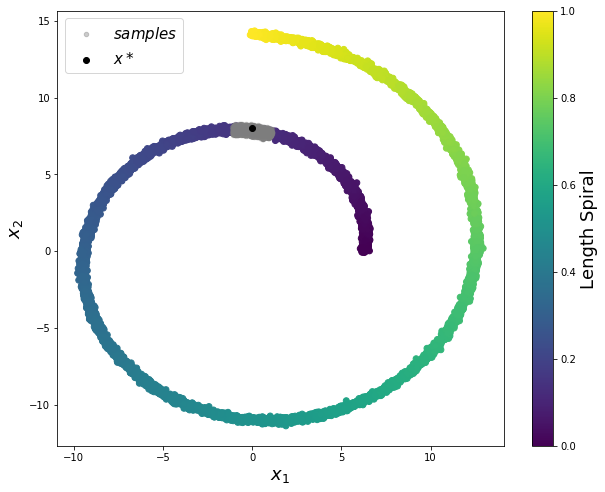

In [32]:
fig, ax = data.plot()
cp = ax.scatter(x_e[:, 0], x_e[:, 1], s=20, c='tab:gray', alpha=0.4, label='$samples$')
cp = ax.scatter(x_explain[0], x_explain[1], c='black', label='$x*$')
color = plt.colorbar(cp)
fig.set_size_inches(10,8)
color.set_label(label='Length Spiral', size=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.legend(fontsize=15)

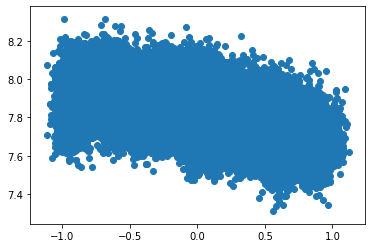

In [33]:
plt.scatter(x_e[:,0], x_e[:,1])

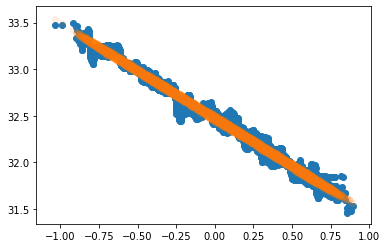

In [40]:
plt.scatter(x_e[:,0], y_e)
plt.scatter(x_e[:, 0], y_p, alpha=0.1)

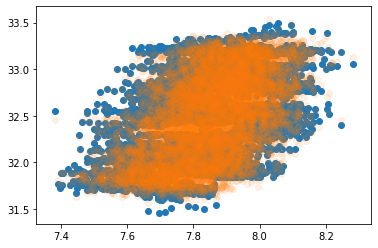

In [41]:
plt.scatter(x_e[:,1], y_e)
plt.scatter(x_e[:, 1], y_p, alpha=0.1)